In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from reservoirs_lshm import Config, read_attributes, read_timeseries
from reservoirs_lshm.models import get_model
from reservoirs_lshm.models.lisflood import plot_lisflood
from reservoirs_lshm.models.camaflood import plot_camaflood
from reservoirs_lshm.calibration import get_calibrator, read_results
from reservoirs_lshm.utils.metrics import KGEmod


In [2]:
path = Path('/home/casadoj/datasets/reservoirs/ResOpsUS/v2.2/results')

grand_id = 355

## CaMa-Flood

In [3]:
config_file = path / 'camaflood' / 'camaflood_2var_5par.yml'

cfg = Config(config_file)

# reservoirs = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()
reservoirs = [355]

attributes = read_attributes(cfg.PATH_DATA / 'attributes', reservoirs)

with open(cfg.PERIODS_FILE, 'rb') as file:
    periods = pickle.load(file)

inputs = [var for var in [cfg.INFLOW, cfg.PRECIPITATION, cfg.EVAPORATION, cfg.DEMAND] if var]
outputs = ['storage', 'outflow']
timeseries = read_timeseries(
    path=cfg.PATH_DATA / 'time_series' / 'csv',
    reservoirs=attributes.index,
    periods=periods,
    variables=inputs + outputs
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
ts = timeseries[grand_id]

# dbname = f'{cfg.PATH_CALIB}/{grand_id}_samples'
dbname = path / cfg.MODEL / 'calibration' / '5par' / 'bivariate' / f'{grand_id}_samples'

# define input time series
inflow = ts[cfg.INFLOW]
precipitation = ts[cfg.PRECIPITATION] if cfg.PRECIPITATION in ts.columns else None
evaporation = ts[cfg.EVAPORATION] if cfg.EVAPORATION in ts.columns else None
demand = ts[cfg.DEMAND] if cfg.DEMAND in ts.columns else None
    
# storage attributes (m3)
Vtot = max(attributes.loc[grand_id, 'CAP_MCM'].item() * 1e6, ts.storage.max())
# Vtot = ts.storage.max()
Vmin = max(0, min(0.1 * Vtot, ts.storage.min()))
# flow attributes (m3/s)
Qmin = max(0, ts.outflow.min())
# catchment area (m2)
catchment = int(attributes.loc[grand_id, 'CATCH_SKM'].item() * 1e6) if cfg.MODEL == 'camaflood' else None
# reservoir area (m2)
Atot = int(attributes.loc[grand_id, 'AREA_SKM'].item() * 1e6)

# configure calibration kwargs
cal_cfg = {}
if cfg.MODEL == 'camaflood':
    cal_cfg.update({'catchment': catchment})
# elif cfg.MODEL == 'mhm':
#     cal_cfg.update({'demand': demand})
# initialize the calibration setup
calibrator = get_calibrator(
    cfg.MODEL,
    parameters=cfg.PARAMETERS,
    inflow=inflow,
    storage=ts.storage,
    outflow=ts.outflow,
    precipitation=precipitation,
    evaporation=evaporation,
    demand=demand,
    Vmin=Vmin,
    Vtot=Vtot,
    Qmin=Qmin,
    Atot=Atot,
    target=cfg.TARGET,
    obj_func=KGEmod,
    spinup=cfg.SPINUP,
    **cal_cfg
)

# read calibration results
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
camaflood = get_model(cfg.MODEL, **calibrated_attrs)

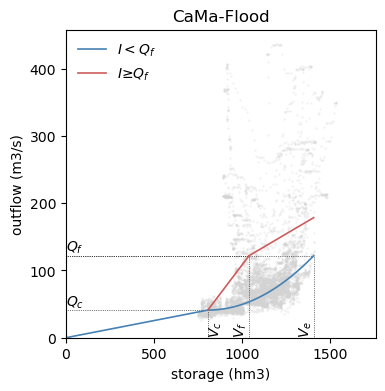

In [5]:
plot_camaflood(camaflood, ts, title='CaMa-Flood')

## LISFLOOD

In [6]:
config_file = path / 'lisflood' / 'lisflood_2var_6par.yml'

cfg = Config(config_file)

In [7]:
# dbname = f'{cfg.PATH_CALIB}/{grand_id}_samples'
dbname = path / cfg.MODEL / 'calibration' / '6par' / 'bivariate' / f'{grand_id}_samples'

# define input time series
inflow = ts[cfg.INFLOW]
precipitation = ts[cfg.PRECIPITATION] if cfg.PRECIPITATION in ts.columns else None
evaporation = ts[cfg.EVAPORATION] if cfg.EVAPORATION in ts.columns else None
demand = ts[cfg.DEMAND] if cfg.DEMAND in ts.columns else None
    
# storage attributes (m3)
Vtot = max(attributes.loc[grand_id, 'CAP_MCM'].item() * 1e6, ts.storage.max())
# Vtot = ts.storage.max()
Vmin = max(0, min(0.1 * Vtot, ts.storage.min()))
# flow attributes (m3/s)
Qmin = max(0, ts.outflow.min())
# catchment area (m2)
catchment = int(attributes.loc[grand_id, 'CATCH_SKM'].item() * 1e6) if cfg.MODEL == 'camaflood' else None
# reservoir area (m2)
Atot = int(attributes.loc[grand_id, 'AREA_SKM'].item() * 1e6)

# configure calibration kwargs
cal_cfg = {}
if cfg.MODEL == 'camaflood':
    cal_cfg.update({'catchment': catchment})
# elif cfg.MODEL == 'mhm':
#     cal_cfg.update({'demand': demand})
# initialize the calibration setup
calibrator = get_calibrator(
    cfg.MODEL,
    parameters=cfg.PARAMETERS,
    inflow=inflow,
    storage=ts.storage,
    outflow=ts.outflow,
    precipitation=precipitation,
    evaporation=evaporation,
    demand=demand,
    Vmin=Vmin,
    Vtot=Vtot,
    Qmin=Qmin,
    Atot=Atot,
    target=cfg.TARGET,
    obj_func=KGEmod,
    spinup=cfg.SPINUP,
    **cal_cfg
)

# read calibration results
results, parameters = read_results(f'{dbname}.csv')

# convert parameter into reservoir attributes
calibrated_attrs = calibrator.pars2attrs(list(parameters.values()))

# declare the reservoir with optimal parameters
lisflood = get_model(cfg.MODEL, **calibrated_attrs)

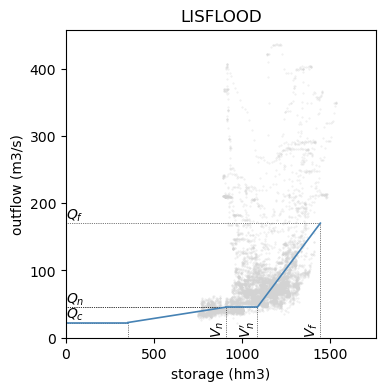

In [8]:
plot_lisflood(lisflood, ts)

## Figure for the paper

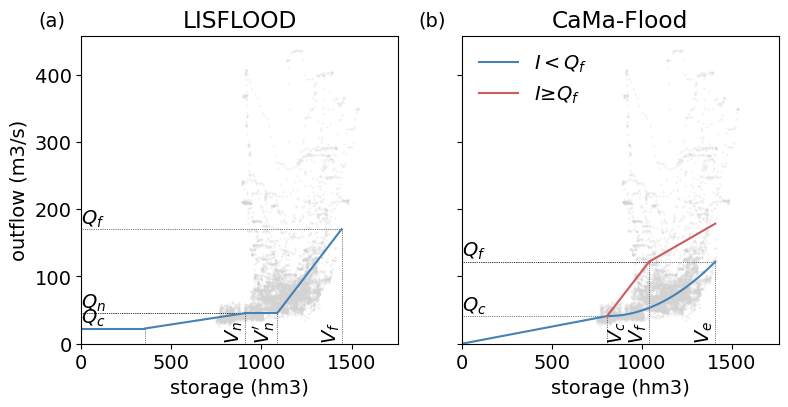

In [10]:
plt.rcParams.update({'font.size': 14})
lw = 1.5
c = 'steelblue'

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9, 4), sharex=True, sharey=True)

# LISFLOOD
plot_lisflood(lisflood, ts, ax=ax[0], lw=lw, title='LISFLOOD')
ax[0].text(-0.05, 1.02, '(a)', ha='right', va='bottom', transform=ax[0].transAxes)

# CAMAFLOOD
plot_camaflood(camaflood, ts, ax=ax[1], lw=lw, title='CaMa-Flood', ylabel=None)
ax[1].text(-0.05, 1.02, '(b)', ha='right', va='bottom', transform=ax[1].transAxes)

plt.savefig('lisflood_camaflood.pdf', dpi=300, bbox_inches='tight')
plt.show()